# ASTM Demonstration

![PVDeg Logo](../PVD_logo.png)

***
2023.06.28
***

**Steps:**
1. Import weather data
2. Calculate installation standoff
3. Calculate installation standoff - with more detail

**Background:**

This example demonstrates the calculation of a minimum standoff distance necessary for roof-mounted PV modules to ensure that the $T_{98}$ operational temperature remains under 70°C, in which case the more rigorous thermal stability testing requirements of IEC TS 63126 would not needed to be considered. We use data from [Fuentes, 1987] to model the approximate exponential decay in temperature, $T(X)$, with increasing standoff distance, $X$, as,

$$ X = -X_0 \ln\left(1-\frac{T_0-T}{\Delta T}\right)$$

where $T_0$ is the temperature for $X=0$ (insulated back) and $\Delta T$ is the temperature difference between an insulated back ($X=0$) and open rack mounting configuration ($X=\infty)$.

The following figure showcases this calulation for the entire United States. We used pvlib and data from the National Solar Radiation Database (NSRDB) to calculate the module temperatures for different mounting configuration and applied our model to obtain the standoff distance for roof-mounted PV systems.


In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
#!pip install pvdeg==0.1.0

In [2]:
import os
import pvlib
import pvdeg
import pandas as pd
from pvdeg import DATA_DIR
import matplotlib.pyplot as plt

## 1. Import Weather Data

The function has two minimum requirements:
- Weather data containing (at least) DNI, DHI, GHI, Temperature, RH, Wind-Speed
- Site meta-data containing (at least) Latitude, Longitude, Time Zone


### Where to get _Free_ Solar Irradiance Data?

There are many different sources of solar irradiance data. For your projects, these are some of the most common:

- [NSRDB](https://maps.nrel.gov/nsrdb-viewer/) - National Solar Radiation Database. You can access data through the website for many locations accross the world, or you can use their [web API](https://developer.nrel.gov/docs/solar/nsrdb/) to download data programmatically. An "API" is an ["application programming interface"](https://en.wikipedia.org/wiki/API), and a "web API" is a programming interface that allows you to write code to interact with web services like the NSRDB.

- [EPW](https://www.energy.gov/eere/buildings/downloads/energyplus-0) - Energy Plus Weather data is available for many locations accross the world. It's in its own format file ('EPW') so you can't open it easily in a spreadsheet program like Excel, but you can use [`pvlib.iotools.read_epw()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.read_epw.html) to get it into a dataframe and use it.

- [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/) - Free global weather data provided by the European Union and derived from many govermental agencies including the NSRDB. PVGIS also provides a web API. You can get PVGIS TMY data using [`pvlib.iotools.get_pvgis_tmy()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_pvgis_tmy.html).

- Perhaps another useful link: https://sam.nrel.gov/weather-data.html

### Where else can you get historical irradiance data?

There are several commercial providers of solar irradiance data. Data is available at different spatial and time resolutions. Each provider offers data under subscription that will provide access to irradiance (and other weather variables) via API to leverage in python.

* [SolarAnywhere](https://www.solaranywhere.com/)
* [SolarGIS](https://solargis.com/)
* [Vaisala](https://www.vaisala.com/en)
* [Meteonorm](https://meteonorm.com/en/)
* [DNV Solar Resource Compass](https://src.dnv.com/)


![NSRDB Example](images/tutorial_1_NSRDB_example.PNG)


### NREL API Key
At the [NREL Developer Network](https://developer.nrel.gov/), there are [APIs](https://en.wikipedia.org/wiki/API) to a lot of valuable [solar resources](https://developer.nrel.gov/docs/solar/) like [weather data from the NSRDB](https://developer.nrel.gov/docs/solar/nsrdb/), [operational data from PVDAQ](https://developer.nrel.gov/docs/solar/pvdaq-v3/), or indicative calculations using [PVWatts](https://developer.nrel.gov/docs/solar/pvwatts/). In order to use these resources from NREL, you need to [register for a free API key](https://developer.nrel.gov/signup/). You can test out the APIs using the `DEMO_KEY` but it has limited bandwidth compared to the [usage limit for registered users](https://developer.nrel.gov/docs/rate-limits/). NREL has some [API usage instructions](https://developer.nrel.gov/docs/api-key/), but pvlib has a few builtin functions, like [`pvlib.iotools.get_psm3()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_psm3.html), that wrap the NREL API, and call them for you to make it much easier to use. Skip ahead to the next section to learn more. But before you do...

**Please pause now to visit https://developer.nrel.gov/signup/ and get an API key.**

### Application Programming Interface (API)
What exactly is an API? Nowadays, the phrase is used interchangeably with a "web API" but in general an API is just a recipe for how to interface with a application programmatically, _IE_: in code. An API could be as simple as a function signature or its published documentation, _EG_: the API for the `solarposition` function is you give it an ISO8601 formatted date with a timezone, the latitude, longitude, and elevation as numbers, and it returns the zenith and azimuth as numbers.

A web API is the same, except the application is a web service, that you access at its URL using web methods. We won't go into too much more detail here, but the most common web method is `GET` which is pretty self explanatory. Look over the [NREL web usage instructions](https://developer.nrel.gov/docs/api-key/) for some examples, but interacting with a web API can be as easy as entering a URL into a browser. Try the URL below to _get_ the PVWatts energy output for a fixed tilt site in [Broomfield, CO](https://goo.gl/maps/awkEcNGzSur9Has18).

https://developer.nrel.gov/api/pvwatts/v6.json?api_key=DEMO_KEY&lat=40&lon=-105&system_capacity=4&azimuth=180&tilt=40&array_type=1&module_type=1&losses=10

In addition to just using your browser, you can also access web APIs programmatically. The most popular Python package to interact with web APIs is [requests](https://docs.python-requests.org/en/master/). There's also free open source command-line tools like [cURL](https://curl.se/) and [HTTPie](https://httpie.io/), and a popular nagware/freemium GUI application called [Postman](https://www.postman.com/).

**If you have an NREL API key please enter it in the next cell.**

In [3]:
NREL_API_KEY = None  # <-- please set your NREL API key here

# note you must use "quotes" around your key, for example:
# NREL_API_KEY = 'DEMO_KEY'  # single or double both work fine

# during the live tutorial, we've stored a dedicated key on our server
if NREL_API_KEY is None:
    try:
        NREL_API_KEY = os.environ[
            "NREL_API_KEY"
        ]  # get dedicated key for tutorial from servier
    except KeyError:
        NREL_API_KEY = "DEMO_KEY"  # OK for this demo, but better to get your own key

## Fetching TMYs from the NSRDB

The NSRDB, one of many sources of weather data intended for PV modeling, is free and easy to access using pvlib. As an example, we'll fetch a TMY dataset for Phoenix, AZ at coordinates [(33.4484, -112.0740)](https://goo.gl/maps/hGV92QHCm5FHJKbf9). 

This function uses [`pvdeg.weather.get()`](https://pvdegradationtools.readthedocs.io/en/latest/_autosummary/pvdeg.weather.html#pvdeg.weather.get), which returns a Python dictionary of metadata and a Pandas dataframe of the timeseries weather data.

This function internally leverages  [`pvlib.iotools.get_psm3()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_psm3.html). However, for some of the NSRDB data relative humidity is not a given parameter, and `pvdeg` calculates  the values from the downloaded data as an internal processing step. 

In [4]:
# This cell does not run on a Collab instal. WE are troubleshooting it, but the next cell performs the same request directly with PVLib.
# If TMY is requested though, relative_humidity will not be included as NSRDB TMY dataset does not have it.
"""
weather_db = 'PSM3'
weather_id = (33.4484, -112.0740)
weather_arg = {'api_key': NREL_API_KEY,
               'email': 'user@mail.com',
               'names': '2021',   # tmy is another common option; right now requesting only 2021 data
               'attributes': [],  # grabs all. to select, could be 'air_temperature', 'dew_point', 'dhi',
               # 'dni', 'ghi', 'surface_albedo', 'surface_pressure', 'wind_direction', 'wind_speed'
               'map_variables': True,
               'leap_day': False}

weather_df, meta = pvdeg.weather.get(weather_db, weather_id, **weather_arg)
""";

In [5]:
weather_df, meta = pvlib.iotools.get_psm3(
    latitude=33.4484,
    longitude=-112.0740,
    api_key=NREL_API_KEY,
    email="silvana.ovaitt@nrel.gov",  # <-- any email works here fine
    names="2020",
    map_variables=True,
    attributes=[],
    leap_day=False,
)

In [6]:
meta

{'Source': 'NSRDB',
 'Location ID': '323705',
 'City': '-',
 'State': '-',
 'Country': '-',
 'Time Zone': -7,
 'Local Time Zone': -7,
 'Clearsky DHI Units': 'w/m2',
 'Clearsky DNI Units': 'w/m2',
 'Clearsky GHI Units': 'w/m2',
 'Dew Point Units': 'c',
 'DHI Units': 'w/m2',
 'DNI Units': 'w/m2',
 'GHI Units': 'w/m2',
 'Solar Zenith Angle Units': 'Degree',
 'Temperature Units': 'c',
 'Pressure Units': 'mbar',
 'Relative Humidity Units': '%',
 'Precipitable Water Units': 'cm',
 'Wind Direction Units': 'Degrees',
 'Wind Speed Units': 'm/s',
 'Cloud Type -15': 'N/A',
 'Cloud Type 0': 'Clear',
 'Cloud Type 1': 'Probably Clear',
 'Cloud Type 2': 'Fog',
 'Cloud Type 3': 'Water',
 'Cloud Type 4': 'Super-Cooled Water',
 'Cloud Type 5': 'Mixed',
 'Cloud Type 6': 'Opaque Ice',
 'Cloud Type 7': 'Cirrus',
 'Cloud Type 8': 'Overlapping',
 'Cloud Type 9': 'Overshooting',
 'Cloud Type 10': 'Unknown',
 'Cloud Type 11': 'Dust',
 'Cloud Type 12': 'Smoke',
 'Fill Flag 0': 'N/A',
 'Fill Flag 1': 'Missing Im

In [7]:
weather_df.head()

,Year,Month,Day,Hour,Minute,temp_air,dhi_clear,dni_clear,ghi_clear,Cloud Type,...,ghi,relative_humidity,solar_zenith,albedo,pressure,precipitable_water,wind_direction,wind_speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm)
2020-01-01 00:30:00-07:00,2020,1,1,0,30,4.9,0.0,0.0,0.0,0,...,0.0,69.51,169.57,0.16,974.0,1.1,54.0,2.3,0.0,0.0
2020-01-01 01:30:00-07:00,2020,1,1,1,30,4.6,0.0,0.0,0.0,0,...,0.0,68.55,163.46,0.16,973.0,1.1,59.0,2.2,0.0,0.0
2020-01-01 02:30:00-07:00,2020,1,1,2,30,4.3,0.0,0.0,0.0,0,...,0.0,68.50,152.03,0.16,973.0,1.1,64.0,2.1,0.0,0.0
2020-01-01 03:30:00-07:00,2020,1,1,3,30,4.0,0.0,0.0,0.0,0,...,0.0,69.10,139.67,0.16,973.0,1.1,68.0,1.9,0.0,0.0
2020-01-01 04:30:00-07:00,2020,1,1,4,30,3.8,0.0,0.0,0.0,0,...,0.0,69.46,127.17,0.16,973.0,1.1,72.0,1.7,0.0,0.0


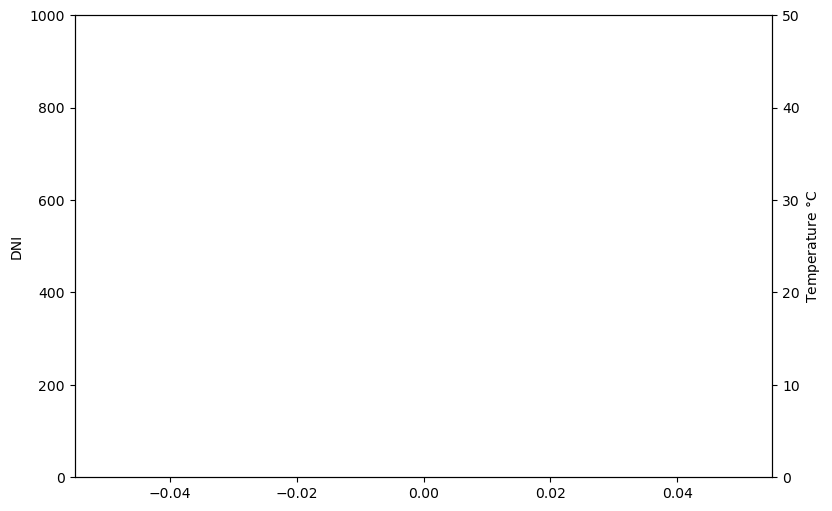

In [8]:
fig, ax1 = plt.subplots(figsize=(9, 6))
# Instantiate a second axes that shares the same x-axis
ax1.plot(
    weather_df.loc["2021-06-28 05:00:00-07:00":"2021-06-28 20:00:00-07:00"][
        "dni_clear"
    ],
    label="DNI",
)
ax2 = ax1.twinx()
ax2.plot(
    weather_df.loc["2021-06-28 05:00:00-07:00":"2021-06-28 20:00:00-07:00"]["temp_air"],
    "r",
    label="Temperature",
)
ax1.set_ylim([0, 1000])
ax2.set_ylim([0, 50])
ax1.set_ylabel("DNI")
ax2.set_ylabel("Temperature $\degree$C");

## 2. Calculate Installation Standoff - Level 1

We use [`pvlib.standards.calc_standoff()`](https://pvdegradationtools.readthedocs.io/en/latest/_autosummary/pvdeg.standards.html#pvdeg.standards.calc_standoff) which takes at minimum the weather data and metadata, and returns the minimum installation distance in centimeters.



In [9]:
standoff = pvdeg.standards.calc_standoff(weather_df=weather_df, meta=meta)

In [10]:
print("Minimum installation distance:", standoff["x"])

Minimum installation distance: 10.055513384986186


## 3. Calculate Installation Standoff - Level 2

Let's take a closer look at the function and some optional parameters.

- level : 1 or 2 (see IEC TS 63216)
- tilt and azimuth : tilt from horizontal of PV module and azimuth in degrees from North
- sky_model : pvlib compatible model for generating sky characteristics (Options: 'isotropic', 'klucher', 'haydavies', 'reindl', 'king', 'perez')
- temp_model : pvlib compatible module temperature model (Options: 'sapm', 'pvsyst', 'faiman', 'sandia')
- module_type : basic module construction (Options: 'glass_polymer', 'glass_glass')
- x_0 : thermal decay constant [cm] (see documentation)
- wind_speed_factor : Wind speed correction factor to account for different wind speed measurement heights between weather database (e.g. NSRDB) and the tempeature model (e.g. SAPM)

In [11]:
standoff = pvdeg.standards.calc_standoff(
    weather_df=weather_df,
    meta=meta,
    level=2,
    tilt=None,
    azimuth=180,
    sky_model="isotropic",
    temp_model="sapm",
    module_type="glass_polymer",
    x_0=6.1,
    wind_speed_factor=1,
)

In [12]:
print("Minimum installation distance:", standoff["x"])

Minimum installation distance: 3.760911305699953
